In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import PowerTransformer
from scipy.stats import pearsonr
from sklearn.metrics import explained_variance_score, mean_squared_error, max_error, mean_absolute_error
from sklearn.feature_selection import SelectFromModel
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.decomposition import PCA

In [2]:
kf = KFold(n_splits=8, shuffle=True, random_state=22)

def printRegressResults(truth, preds):
    corr, pval=pearsonr(truth, preds)
    print("The RVE is: ", explained_variance_score(truth, preds))
    print("The rmse is: ", mean_squared_error(truth, preds, squared=False))
    print("The Correlation Score is: ", corr)
    print("The Maximum Error is: ", max_error(truth, preds))
    print("The Mean Absolute Error is: ", mean_absolute_error(truth, preds))

def Plot_BestValue(values,optimal_value,rmse_train,rmse_test,x_label):
    print("Optimal value is:", optimal_value)
    plt.figure(figsize=(6,4))
    plt.plot(values,rmse_train,label="rmse Train")    
    plt.plot(values,rmse_test,label="rmse Test")
    plt.axvline(x=optimal_value,color="b",label="optimal value")
    plt.grid()
    plt.legend()
    plt.xlabel(x_label)
    plt.ylabel("Root Mean Square Value")
    plt.show() 
    
def TrainAndTest(X,y,function):
    TRUTH_nfold = None
    PREDS_nfold = None
    for train_index, test_index in kf.split(X):
        X_train_nfold, X_test_nfold = X[train_index], X[test_index]
        y_train_nfold, y_test_nfold = y[train_index], y[test_index]
        model = function.fit(X_train_nfold, y_train_nfold)
        preds_test = model.predict(X_test_nfold)
        if TRUTH_nfold is None:
            PREDS_nfold = preds_test
            TRUTH_nfold = y_test_nfold
        else:
            PREDS_nfold = np.hstack((PREDS_nfold, preds_test))
            TRUTH_nfold = np.hstack((TRUTH_nfold, y_test_nfold))
    printRegressResults(TRUTH_nfold, PREDS_nfold)
    plt.figure(figsize=(4,4))
    plt.scatter(PREDS_nfold,TRUTH_nfold)
    plt.plot((0,1), (0,1), c="r")
    plt.grid()
    plt.show()

In [3]:
X_batch, X_ivs, y_batch, col_names = pickle.load(open("drd2_data.pickle", "rb"))
X_train, X_test, y_train, y_test = train_test_split(X_batch, y_batch, test_size=0.25, random_state=22)

### Feature Selection

In [7]:
def naif_model_testingR(X_train, X_test, y_train, y_test):
    #test 3 approaches and print out the results
    
    rfr= RandomForestRegressor()
    rfr.fit(X_train, np.ravel(y_train))

    dtr= DecisionTreeRegressor()
    dtr.fit(X_train, np.ravel(y_train))
    
    lmr=LinearRegression()
    lmr.fit(X_train, np.ravel(y_train))
    
    l = Lasso()
    l.fit(X_train, np.ravel(y_train))
    
    r = Ridge()
    r.fit(X_train,np.ravel(y_train))

    rf_preds=rfr.predict(X_test)
    dt_preds=dtr.predict(X_test)
    lr_preds=lmr.predict(X_test)
    l_preds=l.predict(X_test)
    r_preds=r.predict(X_test)

    print("RVE RFs: %7.4f" % explained_variance_score(y_test, rf_preds))
    print("RVE DTs: %7.4f" % explained_variance_score(y_test, dt_preds))
    print("RVE LRs: %7.4f" % explained_variance_score(y_test, lr_preds))
    print("RVE Lasso: %7.4f" % explained_variance_score(y_test, l_preds))
    print("RVE Ridge: %7.4f" % explained_variance_score(y_test, r_preds))

naif_model_testingR(X_train, X_test, y_train, y_test)

RVE RFs:  0.6161
RVE DTs:  0.2836
RVE LRs:  0.3556
RVE Lasso:  0.0209
RVE Ridge:  0.4143


Processing: 100%|██████████████████████████████| 15/15 [39:11<00:00, 156.76s/it]


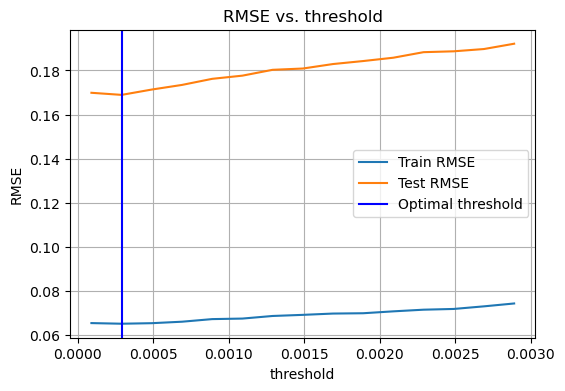

0.00029
0.16893304076035492


In [4]:
t_values = np.arange(0.00009,0.003,0.0002) 
train_rmse_list = []
test_rmse_list = []

for t in tqdm(t_values, desc='Processing'):
    model = RandomForestRegressor(random_state=0)
    sel = SelectFromModel(estimator=model, threshold=t)
    X_train_selected = sel.fit_transform(X_train, np.ravel(y_train))
    X_test_selected = sel.transform(X_test)
    
    model.fit(X_train_selected, np.ravel(y_train))

    train_preds = model.predict(X_train_selected)
    test_preds = model.predict(X_test_selected)

    train_rmse = np.sqrt(mean_squared_error(y_train, train_preds))
    test_rmse = np.sqrt(mean_squared_error(y_test, test_preds))
    train_rmse_list.append(train_rmse)
    test_rmse_list.append(test_rmse)

min_ = np.amin(test_rmse_list)
optimal_t = t_values[np.where(test_rmse_list == min_)[0][0]]

plt.figure(figsize=(6,4))
plt.plot(t_values, train_rmse_list, label='Train RMSE')
plt.plot(t_values, test_rmse_list, label='Test RMSE')
plt.axvline(x=optimal_t,color="b",label='Optimal threshold')
plt.grid()
plt.title('RMSE vs. threshold')
plt.xlabel('threshold')
plt.ylabel('RMSE')
plt.legend()
plt.show()

print(optimal_t)
print(min_)

In [8]:
model = RandomForestRegressor(random_state=0)
sel = SelectFromModel(estimator=model, threshold=optimal_t)
sel.fit(X_batch,np.ravel(y_batch))
nX_train = sel.transform(X_train)
nX_test = sel.transform(X_test)
nX_batch = sel.transform(X_batch)
nX_ivs = sel.transform(X_ivs)

N,M = X_train.shape
features = sel.get_support()
features_selected = np.arange(M)[features]
print('Number of selected features:', len(features_selected))

Number of selected features: 539


In [9]:
power_scaler = PowerTransformer(method='yeo-johnson')
power_scaler.fit(nX_batch)
nX_batch = power_scaler.transform(nX_batch)
nX_ivs = power_scaler.transform(nX_ivs)
nX_train = power_scaler.transform(nX_train)
nX_test = power_scaler.transform(nX_test)

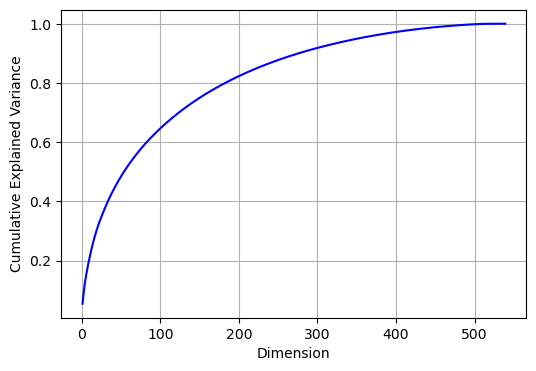

In [10]:
pca = PCA()
pca.fit(nX_batch)
cumsum = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(6,4))
plt.plot(range(1, len(cumsum) + 1), cumsum, linestyle='-', color='b')
plt.xlabel('Dimension')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

### Decision Tree

Processing: 100%|███████████████████████████████| 79/79 [00:27<00:00,  2.89it/s]

Optimal value is: 11


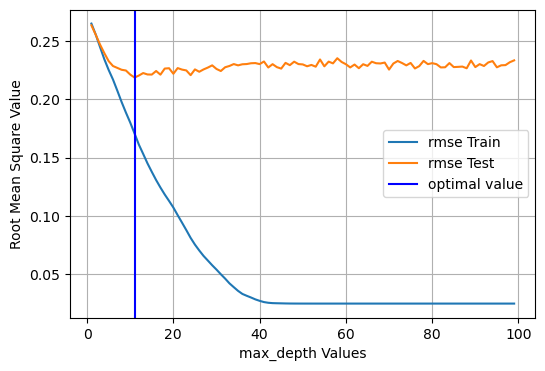

Optimal value is: 11


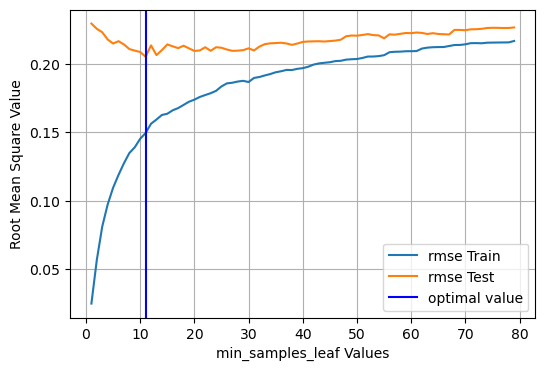

The RVE is:  0.4040130351046799
The rmse is:  0.2135850448162109
The Correlation Score is:  0.6413460724605913
The Maximum Error is:  0.9449090459090911
The Mean Absolute Error is:  0.16347860115088203


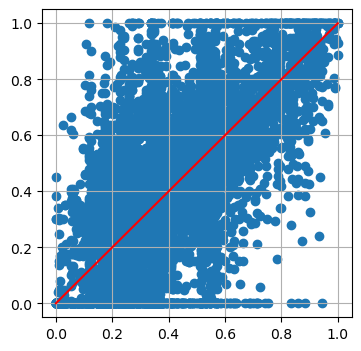

In [11]:
values_DT1 = np.arange(1,100,1)
rmse_train_DT1 = []
rmse_test_DT1 = []
for i in tqdm(values_DT1, desc='Processing'):
    DT1 = DecisionTreeRegressor(max_depth=i).fit(nX_train, y_train)
    preds_train = DT1.predict(nX_train)
    preds_test = DT1.predict(nX_test)
    rmse_train_DT1.append(mean_squared_error(y_train, preds_train, squared=False))
    rmse_test_DT1.append(mean_squared_error(y_test, preds_test, squared=False))
min_DT1 = np.amin(rmse_test_DT1)
optimal_DT1 = values_DT1[np.where(rmse_test_DT1 == min_DT1)[0][0]]

values_DT2 = np.arange(1,80,1)
rmse_train_DT2 = []
rmse_test_DT2 = []
for i in tqdm(values_DT2, desc='Processing'):
    DT2 = DecisionTreeRegressor(min_samples_leaf=i).fit(nX_train, y_train)
    preds_train = DT2.predict(nX_train)
    preds_test = DT2.predict(nX_test)
    rmse_train_DT2.append(mean_squared_error(y_train, preds_train, squared=False))
    rmse_test_DT2.append(mean_squared_error(y_test, preds_test, squared=False))
min_DT2 = np.amin(rmse_test_DT2)
optimal_DT2 = values_DT2[np.where(rmse_test_DT2 == min_DT2)[0][0]]

Plot_BestValue(values_DT1,optimal_DT1,rmse_train_DT1,rmse_test_DT1,'max_depth Values')
Plot_BestValue(values_DT2,optimal_DT2,rmse_train_DT2,rmse_test_DT2,'min_samples_leaf Values')

TrainAndTest(nX_batch,y_batch,DecisionTreeRegressor(max_depth=optimal_DT1,min_samples_leaf=optimal_DT2))

### Random Forest

Processing: 100%|███████████████████████████████| 19/19 [06:53<00:00, 21.76s/it]


Optimal value is: 75


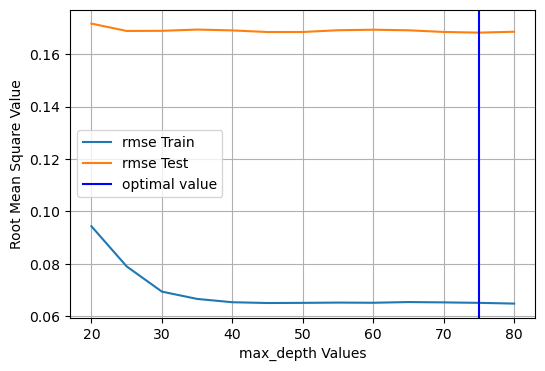

Optimal value is: 90


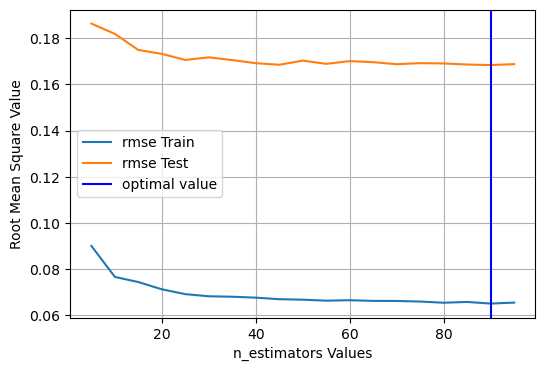

The RVE is:  0.6464363499812585
The rmse is:  0.16454071307571616
The Correlation Score is:  0.8059996499105625
The Maximum Error is:  0.8657408683888888
The Mean Absolute Error is:  0.12244868423679157


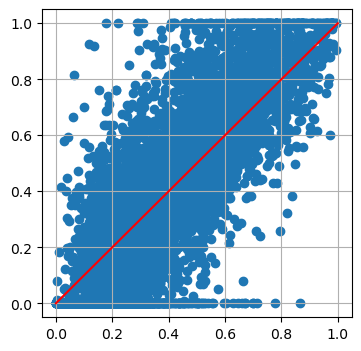

In [12]:
values_RF1 = np.arange(20, 85, 5)  
rmse_train_RF1 = []
rmse_test_RF1 = []
for i in tqdm(values_RF1, desc='Processing'):
    RF1 = RandomForestRegressor(max_depth=i).fit(nX_train, y_train)
    preds_train = RF1.predict(nX_train)
    preds_test = RF1.predict(nX_test)
    rmse_train_RF1.append(mean_squared_error(y_train, preds_train, squared=False))
    rmse_test_RF1.append(mean_squared_error(y_test, preds_test, squared=False))
min_RF1 = np.amin(rmse_test_RF1)
optimal_RF1 = values_RF1[np.where(rmse_test_RF1 == min_RF1)[0][0]]

values_RF2 = np.arange(5, 100, 5)
rmse_train_RF2 = []
rmse_test_RF2 = []
for i in tqdm(values_RF2, desc='Processing'):
    RF2 = RandomForestRegressor(n_estimators=i).fit(nX_train, y_train)
    preds_train = RF2.predict(nX_train)
    preds_test = RF2.predict(nX_test)
    rmse_train_RF2.append(mean_squared_error(y_train, preds_train, squared=False))
    rmse_test_RF2.append(mean_squared_error(y_test, preds_test, squared=False))
min_RF2 = np.amin(rmse_test_RF2)
optimal_RF2 = values_RF2[np.where(rmse_test_RF2 == min_RF2)[0][0]]

Plot_BestValue(values_RF1,optimal_RF1,rmse_train_RF1,rmse_test_RF1,'max_depth Values')
Plot_BestValue(values_RF2,optimal_RF2,rmse_train_RF2,rmse_test_RF2,'n_estimators Values')

TrainAndTest(nX_batch,y_batch,RandomForestRegressor(max_depth=optimal_RF1,n_estimators=optimal_RF2))

### Ridge

Processing: 100%|███████████████████████████████| 20/20 [00:01<00:00, 10.64it/s]


Optimal value is: 580


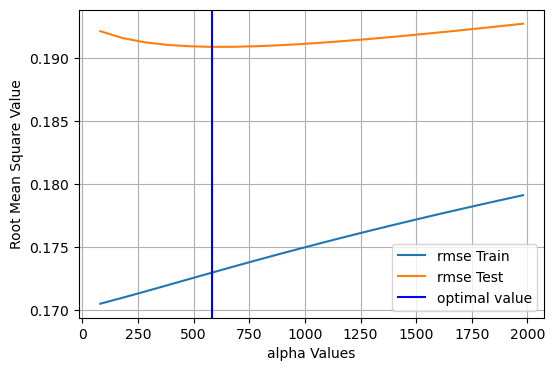

The RVE is:  0.5387864675867988
The rmse is:  0.18787207604301365
The Correlation Score is:  0.7340213151614446
The Maximum Error is:  0.9358194647790848
The Mean Absolute Error is:  0.146846537767245


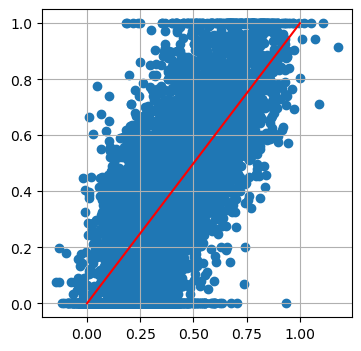

In [13]:
values_R = np.arange(80,2000,100) 
rmse_train_R = []
rmse_test_R = []
for i in tqdm(values_R, desc='Processing'):
    R = Ridge(alpha=i).fit(nX_train, y_train)
    preds_train = R.predict(nX_train)
    preds_test = R.predict(nX_test)
    rmse_train_R.append(mean_squared_error(y_train, preds_train, squared=False))
    rmse_test_R.append(mean_squared_error(y_test, preds_test, squared=False))
min_R = np.amin(rmse_test_R)
optimal_R = values_R[np.where(rmse_test_R == min_R)[0][0]]

Plot_BestValue(values_R,optimal_R,rmse_train_R,rmse_test_R,'alpha Values')

TrainAndTest(nX_batch,y_batch,Ridge(alpha=optimal_R))

### KNN Neighbors

Processing: 100%|███████████████████████████████| 19/19 [00:21<00:00,  1.14s/it]


Optimal value is: 5


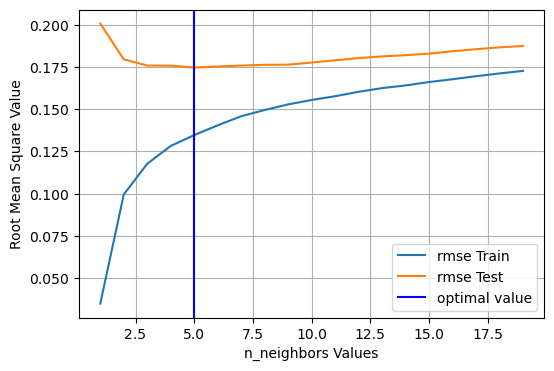

The RVE is:  0.6292377780441502
The rmse is:  0.16845353808462446
The Correlation Score is:  0.7953124646552906
The Maximum Error is:  0.924742501
The Mean Absolute Error is:  0.12139408505961564


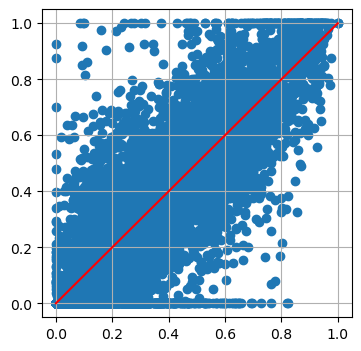

In [14]:
values_KNN = np.arange(1, 20, 1)
rmse_train_KNN = []
rmse_test_KNN = []
for i in tqdm(values_KNN, desc='Processing'):
    KNN = KNeighborsRegressor(n_neighbors=i).fit(nX_train, y_train)
    preds_train = KNN.predict(nX_train)
    preds_test = KNN.predict(nX_test)
    rmse_train_KNN.append(mean_squared_error(y_train, preds_train, squared=False))
    rmse_test_KNN.append(mean_squared_error(y_test, preds_test, squared=False))
min_KNN = np.amin(rmse_test_KNN)
optimal_KNN = values_KNN[np.where(rmse_test_KNN == min_KNN)[0][0]]

Plot_BestValue(values_KNN,optimal_KNN,rmse_train_KNN,rmse_test_KNN,'n_neighbors Values')

TrainAndTest(nX_batch,y_batch,KNeighborsRegressor(n_neighbors=optimal_KNN))

### Support Vector Machine

Processing: 100%|█████████████████████████████████| 3/3 [01:14<00:00, 24.88s/it]


Optimal value is: 0.8999999999999999


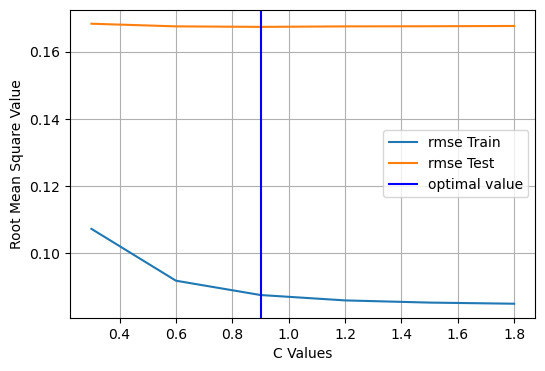

Optimal value is: 0.001


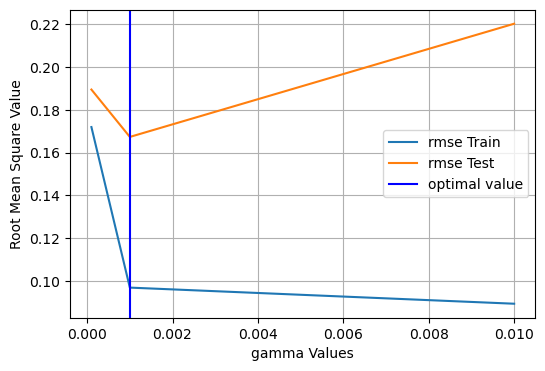

The RVE is:  0.6628946451914821
The rmse is:  0.16066180935701485
The Correlation Score is:  0.815004592481446
The Maximum Error is:  0.8413160906737608
The Mean Absolute Error is:  0.12216484744284835


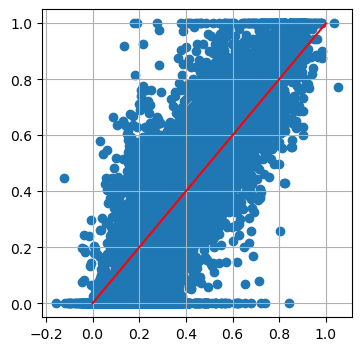

In [15]:
values_SVR1 = np.arange(0.3, 2, 0.3)
rmse_train_SVR1 = []
rmse_test_SVR1 = []
for i in tqdm(values_SVR1, desc='Processing'):
    SVR1 = SVR(C=i).fit(nX_train, y_train)
    preds_train = SVR1.predict(nX_train)
    preds_test = SVR1.predict(nX_test)
    rmse_train_SVR1.append(mean_squared_error(y_train, preds_train, squared=False))
    rmse_test_SVR1.append(mean_squared_error(y_test, preds_test, squared=False))
min_SVR1 = np.amin(rmse_test_SVR1)
optimal_SVR1 = values_SVR1[np.where(rmse_test_SVR1 == min_SVR1)[0][0]]

values_SVR2 = [0.010, 0.0010, 0.00010]
rmse_train_SVR2 = []
rmse_test_SVR2 = []
for i in tqdm(values_SVR2, desc='Processing'):
    SVR2 = SVR(gamma=i).fit(nX_train, y_train)
    preds_train = SVR2.predict(nX_train)
    preds_test = SVR2.predict(nX_test)
    rmse_train_SVR2.append(mean_squared_error(y_train, preds_train, squared=False))
    rmse_test_SVR2.append(mean_squared_error(y_test, preds_test, squared=False))
min_SVR2 = np.amin(rmse_test_SVR2)
optimal_SVR2 = values_SVR2[np.where(rmse_test_SVR2 == min_SVR2)[0][0]]


Plot_BestValue(values_SVR1,optimal_SVR1,rmse_train_SVR1,rmse_test_SVR1,'C Values')
Plot_BestValue(values_SVR2,optimal_SVR2,rmse_train_SVR2,rmse_test_SVR2,'gamma Values')

TrainAndTest(nX_batch,y_batch,SVR(C=optimal_SVR1,gamma=optimal_SVR2))

### Gradient Boosting

Processing: 100%|█████████████████████████████████| 9/9 [01:12<00:00,  8.10s/it]


Optimal value is: 900


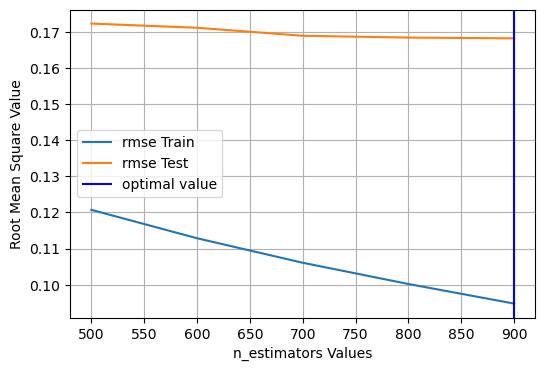

Optimal value is: 0.4


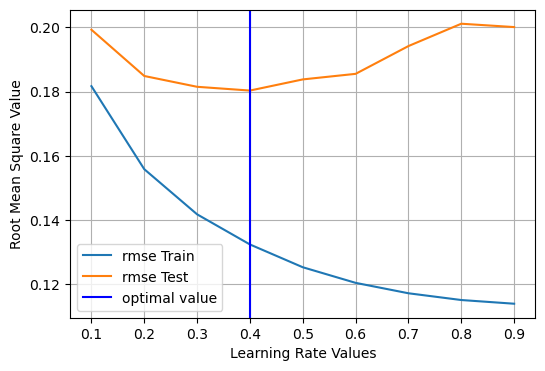

The RVE is:  0.6046993865764309
The rmse is:  0.1739450479379792
The Correlation Score is:  0.7836299845640711
The Maximum Error is:  0.9391085044077482
The Mean Absolute Error is:  0.12847071840601612


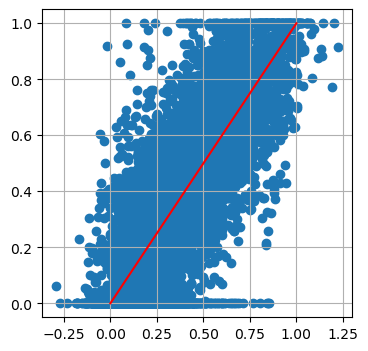

In [16]:
rmse_train_GB1 = []
rmse_test_GB1 = []
values_GB1 = np.arange(500,1000,100)
for i in tqdm(values_GB1, desc='Processing'):
    GB1 = GradientBoostingRegressor(n_estimators=i).fit(nX_train, y_train)
    preds_train = GB1.predict(nX_train)
    preds_test = GB1.predict(nX_test)
    rmse_train_GB1.append(mean_squared_error(y_train, preds_train, squared=False))
    rmse_test_GB1.append(mean_squared_error(y_test, preds_test, squared=False))
min_GB1 = np.amin(rmse_test_GB1)
optimal_GB1 = values_GB1[np.where(rmse_test_GB1 == min_GB1)[0][0]]

rmse_train_GB2 = []
rmse_test_GB2 = []
values_GB2 =  np.arange(0.1, 1,0.1)
for i in tqdm(values_GB2, desc='Processing'):
    GB2 = GradientBoostingRegressor(learning_rate=i).fit(nX_train, y_train)
    preds_train = GB2.predict(nX_train)
    preds_test = GB2.predict(nX_test)
    rmse_train_GB2.append(mean_squared_error(y_train, preds_train, squared=False))
    rmse_test_GB2.append(mean_squared_error(y_test, preds_test, squared=False))
min_GB2 = np.amin(rmse_test_GB2)
optimal_GB2 = values_GB2[np.where(rmse_test_GB2 == min_GB2)[0][0]]

Plot_BestValue(values_GB1,optimal_GB1,rmse_train_GB1,rmse_test_GB1,'n_estimators Values')
Plot_BestValue(values_GB2,optimal_GB2,rmse_train_GB2,rmse_test_GB2,'Learning Rate Values')

TrainAndTest(nX_batch,y_batch,GradientBoostingRegressor(n_estimators=optimal_GB1,learning_rate=optimal_GB2))

### AdaBooster

In [ ]:
svr = SVR(C=optimal_SVR1,gamma=optimal_SVR2,epsilon=0.1,kernel='rbf')
values_AB1 = np.arange(20, 50, 5)
rmse_train_AB1 = []
rmse_test_AB1 = []
for i in tqdm(values_AB1, desc='Processing'):
    AB1 = AdaBoostRegressor(base_estimator=svr,n_estimators=i).fit(nX_train, y_train)
    preds_train = AB1.predict(nX_train)
    preds_test = AB1.predict(nX_test)
    rmse_train_AB1.append(mean_squared_error(y_train, preds_train, squared=False))
    rmse_test_AB1.append(mean_squared_error(y_test, preds_test, squared=False))
min_AB1 = np.amin(rmse_test_AB1)
optimal_AB1 = values_AB1[np.where(rmse_test_AB1 == min_AB1)[0][0]]

values_AB2 =  np.arange(0.1, 1,0.1)
rmse_train_AB2 = []
rmse_test_AB2 = []
for i in tqdm(values_AB2, desc='Processing'):
    AB2 = AdaBoostRegressor(base_estimator=svr,learning_rate=i).fit(nX_train, y_train)
    preds_train = AB2.predict(nX_train)
    preds_test = AB2.predict(nX_test)
    rmse_train_AB2.append(mean_squared_error(y_train, preds_train, squared=False))
    rmse_test_AB2.append(mean_squared_error(y_test, preds_test, squared=False))
min_AB2 = np.amin(rmse_test_AB2)
optimal_AB2 = values_AB2[np.where(rmse_test_AB2 == min_AB2)[0][0]]

Plot_BestValue(values_AB1,optimal_AB1,rmse_train_AB1,rmse_test_AB1,'n_estimators Values')
Plot_BestValue(values_AB2,optimal_AB2,rmse_train_AB2,rmse_test_AB2,'learning_rate Values')

TrainAndTest(nX_batch,y_batch,AdaBoostRegressor(base_estimator=svr,n_estimators=optimal_AB1,learning_rate=optimal_AB2))

### Independent Validation Set

In [17]:
best_regressor = SVR(C=optimal_SVR1,gamma=optimal_SVR2).fit(nX_batch, y_batch)
ivs_preds = best_regressor.predict(nX_ivs)

group_number = '07'
output_file = f'{group_number}.txt'
with open(output_file, 'w') as file:
    for pred in ivs_preds:
        file.write(f'{pred}\n')